<a href="https://colab.research.google.com/github/AmirJffr/DataScience-and-Machine-Learning-Master-SI/blob/main/Assignements/Part%205/Assignment_part_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### DSML investigation

You are part of the Suisse Impossible Mission Force, or SIMF for short. You need to uncover a rogue agent that is trying to steal sensitive information.

Your mission, should you choose to accept it, is to find that agent before stealing any classified information. Good luck!

# Assignment part five

More information came in that suggests that the rogue agent is tampering with the sentiment annotation system of the SIMF which analyses news documents and marks their sentiment for intelligence analysis tasks.

This annotation is crucial to identify documents expressing negativity towards Switzerland and its allies.

Each document contains a column which shows which user accessed it. We know that the rogue agent accessed only the documents whose negative sentiment was high, and then changed them to positive or neutral. We will use a huggingface model to identify which records have been tampered with.


[You can find more models on this link](https://huggingface.co/models?sort=trending)


In [1]:
# Import required packages
from transformers import pipeline, DataCollatorWithPadding
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split

torch.cuda.is_available()

# Import standard libraries
import pandas as pd
import numpy as np
import math
import bs4 as bs
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Import for text analytics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


# Import metrics libraries
from sklearn.metrics import confusion_matrix, accuracy_score



# 1. Getting to know our data

In [2]:

df = pd.read_excel('https://raw.githubusercontent.com/michalis0/DataScience_and_MachineLearning/master/Assignements/Part%205/data/Reduced_Set_2100.xlsx')

In [3]:
df.head(2)

,company,title,news,evaluation,year,month,day
0,APPLE,Tourists snap up British iPads to smuggle into...,IT'S the digital version of the slow boat to C...,negative,2011,4,17
1,CHEVRON,AFTER SEATTLE; Anarchists get organized.,"For Juliette Beck, it began with the story of ...",negative,2000,4,17


### 2. Re-evaluating with SIMF's Model

We will re-evaluate the sentiment on the `title` column using a sentiment analysis pipeline based on the `finiteautomata/bertweet-base-sentiment-analysis` model. This is a sentiment analysis model trained on ~40k tweets. It classifies a text as `POS` (positive), `NEU` (neutral), or `NEG` (negative) sentiment.

Initialize a sentiment analysis classifier with the pre-trained model mentioned above, making sure to set the correct value for the `task` parameter.

**Note**: Set the `top_k` argument to `None` to retrieve the probabilities for all possible sentiment labels in the output.

_This process may take some time._

In [4]:
sentiment_analysis = pipeline(task='sentiment-analysis', model='finiteautomata/bertweet-base-sentiment-analysis', top_k=None)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/949 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/338 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Device set to use cpu


Apply the sentiment classifier to the `title` column and assign the corresponding sentiment labels to a new column in your dataframe.

Make sure to convert the sentiment labels from the model by replacing them with more descriptive terms like this:
- **NEU**: neutral
- **NEG**: negative
- **POS**: positive

*Hint: Be mindful of the format of the classifier’s output.*

_Beware that applying the model on all of the rows may take some time_

In [7]:
sentiment_results = sentiment_analysis(df["title"].tolist())

sentiment_mapping = {
    'NEU': 'neutral',
    'NEG': 'negative',
    'POS': 'positive'
}

sentiment_labels = [sentiment_mapping.get(result[0]['label'], None) for result in sentiment_results if isinstance(result, list) and len(result) > 0 and isinstance(result[0], dict) and 'label' in result[0]]

df["sentiment"] = sentiment_labels
display(df.head())

,company,title,news,evaluation,year,month,day,sentiment
0,APPLE,Tourists snap up British iPads to smuggle into...,IT'S the digital version of the slow boat to C...,negative,2011,4,17,neutral
1,CHEVRON,AFTER SEATTLE; Anarchists get organized.,"For Juliette Beck, it began with the story of ...",negative,2000,4,17,neutral
2,Exxon Mobil,$10bn oil payout voided,SAN FRANCISCO: An appeal court yesterday voide...,negative,2001,11,9,negative
3,WAL MART STORES,Craft capitalism: Just do it yourself; Web mar...,The declaration from the Handmade Consortium m...,negative,2007,12,15,positive
4,Exxon Mobil,Chevron gas project gets state green light,SYDNEY: Chevron has received final environment...,negative,2007,9,8,neutral


Now, display the number of unique sentiment evaluations for both the Hugging Face and SIMF models to compare the distribution of labels.

Next, calculate and display the accuracy of the Hugging Face sentiment analysis compared to the SIMF evaluation. Finally, visualize the comparison using a heatmap of the confusion matrix to better understand where the two models align or differ.

Hugging Face Sentiment Distribution:


,count
sentiment,
neutral,1380
negative,384
positive,336



SIMF Sentiment Distribution:


,count
evaluation,
negative,700
neutral,700
positive,700



Accuracy of Hugging Face model compared to SIMF evaluation: 0.43


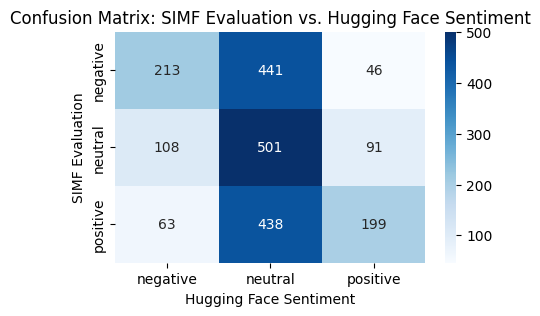

In [11]:
print("Hugging Face Sentiment Distribution:")
display(df['sentiment'].value_counts())

print("\nSIMF Sentiment Distribution:")
display(df['evaluation'].value_counts())

accuracy = accuracy_score(df['evaluation'], df['sentiment'])
print(f"\nAccuracy of Hugging Face model compared to SIMF evaluation: {accuracy:.2f}")

cm = confusion_matrix(df['evaluation'], df['sentiment'], labels=['negative', 'neutral', 'positive'])
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Hugging Face Sentiment')
plt.ylabel('SIMF Evaluation')
plt.title('Confusion Matrix: SIMF Evaluation vs. Hugging Face Sentiment')
plt.show()

**Q1. Does the SIMF sentiment classifier predicts more samples to be "neutral"  compared to the Hugging Face sentiment classifier?**

No.

## 2.1 Entries match both the SIMF model **and** the hugginface model

The SIMF model values are found in the `evaluation` column, while the hugginface model values should be found in the `new_column`, which you added to the table in the previous step.

Display:
*   The rows/records with same sentiment for both models.
*   The number of matching values.
*   The share of matching values of the total number of values.



In [14]:
same_sentiment = df[df['evaluation'] == df['sentiment']]
display(same_sentiment.head(5))
print(f"Number of matching values: {len(same_sentiment)}")
print(f"Share of matching values: {len(same_sentiment) / len(df):.2f}")

,company,title,news,evaluation,year,month,day,sentiment
2,Exxon Mobil,$10bn oil payout voided,SAN FRANCISCO: An appeal court yesterday voide...,negative,2001,11,9,negative
12,MICROSOFT,"Greenpeace slams Microsoft, Nintendo's 'toxic'...",AMSTERDAM - Microsoft and Nintendo are taking ...,negative,2007,11,29,negative
13,PEPSICO,PESTICIDE PANIC,NEW DELHI: India's top court has asked local s...,negative,2006,8,6,negative
14,Exxon Mobil,"High-cost oil projects may be wasted, report says",More than $1tn (£600bn) is being gambled on hi...,negative,2014,5,8,negative
23,Exxon Mobil,MORE TOXIC SLUDGE FEARED IN WATERWAY,WORKERS BUILDING a park on Newtown Creek hit u...,negative,2005,2,24,negative


Number of matching values: 913
Share of matching values: 0.43


**Q2. How many entries are identical between the SIMF model evaluation and the Hugging Face model evaluation?**

*Note: Provide your answer as an integer (e.g., 80).*

913

## 2.2 Entries that do not match both models
Identify all non matching entries.

Create a subset with all the entries that were evaluated differently by the two models.

In [15]:
no_match = df[df['evaluation'] != df['sentiment']]
display(no_match.head(5))

,company,title,news,evaluation,year,month,day,sentiment
0,APPLE,Tourists snap up British iPads to smuggle into...,IT'S the digital version of the slow boat to C...,negative,2011,4,17,neutral
1,CHEVRON,AFTER SEATTLE; Anarchists get organized.,"For Juliette Beck, it began with the story of ...",negative,2000,4,17,neutral
3,WAL MART STORES,Craft capitalism: Just do it yourself; Web mar...,The declaration from the Handmade Consortium m...,negative,2007,12,15,positive
4,Exxon Mobil,Chevron gas project gets state green light,SYDNEY: Chevron has received final environment...,negative,2007,9,8,neutral
5,CHEVRON,RIVALS WILL ACCUSE BP,[…] BP was expected to be hung out to dry by r...,negative,2010,6,15,neutral


## 2.3 Predicted negative, but evaluated as neutral or positive by the SIMF model

Remember, we are looking at document that were tempered (altered). We suspect that the rogue agent accessed only the documents whose negative sentiment was high, and was then changed to positive or neutral.

Create a subset with only those values, which appear as 'positive' or 'neutral' in the original `evaluation` column, but are marked as having a 'negative' sentiment by the new hugginface model.

**This subset is what we'll call the end of the assignment : "Altered Documents".**

In [66]:
altered_documents = df[((df['evaluation'] == 'positive') | (df['evaluation'] == 'neutral')) & (df['sentiment'] == 'negative')]
display(altered_documents.head(5))
altered_documents.shape


,company,title,news,evaluation,year,month,day,sentiment
702,BANK OF AMERICA,Letters: Anger simmers over energy bills; Thes...,"[…] Ending our addiction to fossil fuels, slas...",neutral,2013,10,17,negative
715,VERIZON COMMUNICATIONS,So How Contaminated Is the Old Nuclear Plant?,"[…] From 1952 to 1966, when operations ceased ...",neutral,2002,1,13,negative
722,CITIGROUP,Front: Carbon bubble 'creates global economic ...,The world could be heading for a major economi...,neutral,2013,4,19,negative
733,CITIGROUP,Report says officials are shortsighted big spe...,Government officials are guilty of wasting mon...,neutral,2003,11,27,negative
738,CITIGROUP,Miners to bear cost of climate toll,"RESOURCE companies, along with transporter Tol...",neutral,2006,12,11,negative


(171, 8)

**Q3. How many entries were changed from a negative evaluation (in the Hugging Face model) to a neutral or positive evaluation (by the SIMF model)?**

*Note: Provide your answer as an integer (e.g., 45).*


171

# 3. Use the ChangeLog dataframe to identify the usersID's who edited the entries.

Consider the subset you created in the previous step : *the altered documents*.

By combining it with ChangeLog, display only those userIDs, that belong to the people who tried to mask the 'negative' sentiments by assigning these sentences a 'positive' or 'neutral' value.

In other words, match the previous subset with corresponding UserIDs.

In [67]:
ChangeLog = pd.read_csv('https://raw.githubusercontent.com/michalis0/DataScience_and_MachineLearning/master/Assignements/Part%205/data/ChangeLogFix.csv')

In [68]:
display(ChangeLog.head(10))

,UserID,title
0,[327047],Tourists snap up British iPads to smuggle into...
1,[401818],Tourists snap up British iPads to smuggle into...
2,[564061],Tourists snap up British iPads to smuggle into...
3,[446376],Tourists snap up British iPads to smuggle into...
4,[242912],AFTER SEATTLE; Anarchists get organized.
5,[645264],AFTER SEATTLE; Anarchists get organized.
6,[654139],$10bn oil payout voided
7,[162287],$10bn oil payout voided
8,[682811],$10bn oil payout voided
9,[910568],Craft capitalism: Just do it yourself; Web mar...


In [69]:
suspects = altered_documents.merge(ChangeLog, on='title', how='inner')
display(suspects.head(5))

,company,title,news,evaluation,year,month,day,sentiment,UserID
0,BANK OF AMERICA,Letters: Anger simmers over energy bills; Thes...,"[…] Ending our addiction to fossil fuels, slas...",neutral,2013,10,17,negative,[241404]
1,BANK OF AMERICA,Letters: Anger simmers over energy bills; Thes...,"[…] Ending our addiction to fossil fuels, slas...",neutral,2013,10,17,negative,[535048]
2,BANK OF AMERICA,Letters: Anger simmers over energy bills; Thes...,"[…] Ending our addiction to fossil fuels, slas...",neutral,2013,10,17,negative,[780084]
3,BANK OF AMERICA,Letters: Anger simmers over energy bills; Thes...,"[…] Ending our addiction to fossil fuels, slas...",neutral,2013,10,17,negative,[679196]
4,VERIZON COMMUNICATIONS,So How Contaminated Is the Old Nuclear Plant?,"[…] From 1952 to 1966, when operations ceased ...",neutral,2002,1,13,negative,[850103]


**Q4. Which of the following users remain suspects when considering only the documents evaluated as negative by the Hugging Face model but not by the SIMF model?**

*Note: Select among the following answers*

In [81]:
ids = ['[241404]', '[850103]', '[515957]', '[535048]', '[910222]']
sus_ids = suspects['UserID'].tolist()

true_ids = [user_id for user_id in ids if user_id in sus_ids]

print("User IDs present in the suspects list:")
for user_id in true_ids:
    print(user_id)

User IDs present in the suspects list:
[241404]
[850103]
[515957]
[535048]


### 4. Identifying Key Information in the Altered Documents

In this section, we will use the **TF-IDF** (Term Frequency-Inverse Document Frequency) features to identify significant terms in the *altered documents*.

Start by creating a list of all the original texts from the `news` column in the dataframe `df`.


In [70]:
news_text = df['news'].tolist()


Initialize the `TfidfVectorizer` with unigrams (`ngram_range=(1, 1)`) and set the `stop_words` parameter to `'english'` to exclude common English words from the analysis.


Apply the vectorizer to the corpus of text and convert the resulting document-term matrix into a DataFrame for easy visualization and analysis.


In [71]:
vector = TfidfVectorizer(ngram_range=(1, 1), stop_words='english')
tfidf_matrix = vector.fit_transform(news_text)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vector.get_feature_names_out())

We now want to focus solely on the **"altered documents"**.

To do this, use the previously created list that contains the documents where the Hugging Face model gave a **negative** evaluation, but the SIMF model evaluated them as **neutral** or **positive**.

From this list of documents, extract the corresponding text from the `news` column to obtain a list of articles.

In [72]:
altered_text = altered_documents['news']

Now, we will identify the document that stands out the most among the altered documents based on the TF-IDF values.

1. **Filter the TF-IDF DataFrame**: Keep only the entries from the `tfidf_df` that correspond to the tampered documents.
   
2. **Sum TF-IDF Values**: For each tampered document, calculate the sum of the TF-IDF values across all tokens. This gives an overall importance score for each document.

3. **Find the Most Significant Document**: Identify the document with the highest summed TF-IDF value, which stands out the most. Retrieve its index from the original DataFrame `df` and display the details of this document.

In [73]:
filtered_tfidf_df = tfidf_df.loc[altered_text.index]
tfidf_sums = filtered_tfidf_df.sum(axis=1)
most_significant_index = tfidf_sums.idxmax()
display(df.loc[most_significant_index])

,1761
company,GENERAL ELECTRIC
title,Force of Nature; Environmentalism is no longer...
news,It seems like a hippie entrepreneur's dream co...
evaluation,positive
year,2006
month,8
day,14
sentiment,negative


**Q5. What is the name's company of the most important altered document?**

*Note: The most important altered document means the document with the highest summed TF-IDF value.*

General Electric

Now, across the altered documents, let's identify the words that stand out the most, meaning those with the highest summed TF-IDF values.

To achieve this, sum the values of each column in the altered TF-IDF dataframe, since each column represents a token. Then, sort these summed values in descending order to easily identify the top 4 words with the highest TF-IDF scores.

Once you have these top 4 words, count in how many *altered documents* each top word appeared.

In [79]:
summed_tfidf = filtered_tfidf_df.sum(axis=0)
top_words = summed_tfidf.sort_values(ascending=False).head(4)
display(top_words)
counts = {}
for word in top_words.index:
    counts[word] = altered_text.str.contains(word, case=False).sum()

print("\nCounts of top words in altered documents:")
display(counts)

,0
carbon,5.759377
said,5.589130
energy,5.010363
climate,4.983437



Counts of top words in altered documents:


{'carbon': np.int64(58),
 'said': np.int64(97),
 'energy': np.int64(70),
 'climate': np.int64(49)}

**Q6. What is the token with the highest summed TF-IDF value?**

*Note: Select among the following answers*

Carbon

**Q7. In how many altered documents do the third most frequent word appeared ?**

*Note: Provide your answer as an integer (e.g., 45).*

70

## Your investigation is progressing effectively, and the list of suspects is narrowing down.

**Don't forget to answer the quiz and submit your code on Moodle before the end of the deadline.**